### Трениране на модел по изиграни мачове на League of Legends
Стойностите които ще се опитвам да отгатвам са на коя роля е играл даден играч спрямо данните за играта.

##### За данни за играчите използвам participants.csv:
`
ID (cross-references the Stats table)
Match ID (cross-references the Matches table)
Player (1-5 blue team, 6-10 red team)
Champion ID (Check the data dragon)
SS1: summoner spell on D (should be Flash)
SS2: summoner spell on F (should not be Flash)
Role (SOLO for top and mid, NONE for jungle, DUO_CARRY or DUO_SUPPORT for botlane)
Position (bot/jungle/top/mid)
`
##### За данни от игрите използвам stats1.csv:
`
ID (cross-references the Participants table)
Win - did the player win? (bool)
Item 1 ... item 6 (check DDragon)
Trinket (check DDragon)
Kills
Deaths
Assists
Largest killing spree
Largest multi kill
Killing sprees
Longest time spent living
Double kills
Triple kills
Quadra kills
Pentakills
Legendary kills (> penta)
Total damage
Magic damage
Physical damage
True damage
Larget crit
Total damage to champs
Magic dmg to champs
Physical dmg to champs
True dmg to champs
Total amount healed
Total units healed
Damage self mitigated
Damage to objectives
Damage to turrets
Vision score
Time CCing others
Total damage taken
Magic dmg taken
Physical dmg taken
True dmg taken
Gold earned
Gold spent
Turrets killed
Inhibitors destroyed
Total minions/monsters killed
Neutral minions killed
Own jungle monsters killed
Enemy jungle monsters killed
Total CC time dealt
Champion level
Pinks bought
Wards bought
Wards placed
Wards killed
First blood (boolean)
`

#### Подреждане на данните
На първо време трябва да подредя данните от participants, защото искам в колона `role` да има само стойностите:
- MID
- TOP
- JUNGLE
- ADC
- SUPPORT

В момента всички тролски игри не са махнати и има комбинации роля + позиция от сорта на DUO MID.
Също така забелязах че роля `NONE` отговаря почти пълно на позиция `JUNGLE`. Общо взето правя смесица между колоните `role` и `position` и така получените стойности ще са ми лейбълите на данните.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mglearn

from IPython.display import display

%matplotlib inline
pd.options.display.max_rows = 15

In [2]:
players = pd.read_csv('data/lol-detailed/participants.csv').head(20000)
#players

,id,matchid,player,championid,ss1,ss2,role,position
0,9,10,1,19,4,11,NONE,JUNGLE
1,10,10,2,267,3,4,DUO_SUPPORT,BOT
2,11,10,3,119,7,4,DUO_CARRY,BOT
3,12,10,4,114,12,4,SOLO,TOP
4,13,10,5,112,4,3,SOLO,MID
5,14,10,6,72,11,4,NONE,JUNGLE
6,15,10,7,3,4,12,SOLO,TOP
...,...,...,...,...,...,...,...,...
19993,20002,2009,4,40,4,3,DUO_SUPPORT,BOT
19994,20003,2009,5,51,7,4,DUO_CARRY,BOT


In [3]:
players.role.value_counts()

SOLO           7847
NONE           4075
DUO_SUPPORT    3758
DUO_CARRY      3758
DUO             562
Name: role, dtype: int64

Следните позиции са проблемни `SOLO` `NONE` `DUO`. Останалите просто ще ги преименувам на `SUPPORT` и `ADC`.

In [4]:
players.loc[players.role == 'SOLO'].position.value_counts()

TOP    3960
MID    3847
BOT      40
Name: position, dtype: int64

In [5]:
players.loc[players.role == 'NONE'].position.value_counts()

JUNGLE    4056
BOT         15
MID          4
Name: position, dtype: int64

In [6]:
players.loc[players.role == 'DUO'].position.value_counts()

BOT    522
MID     38
TOP      2
Name: position, dtype: int64

In [7]:
# видях че има някои които са role-'NONE' и position - 'MID'. Тях ги слагам на роля MID.
# другите коитo са BOT & NONE, ще премахна защото подозирам че са тролски игри, и накрая 
# тези които остават ще преименувам от NONE на JUNGLE

players.loc[(players.role == 'NONE') & (players.position == 'MID'), 'role'] = 'MID'
players = players.loc[((players.role == 'NONE') & (players.position != 'BOT') | (players.role != 'NONE'))]
players.loc[players.role == 'NONE', 'role'] = 'JUNGLE'

# има играчи които са SOLO BOT - искам да ги махна
# другите играчи които са SOLO MID & SOLO TOP са ОК

players.loc[players.role == 'SOLO'] = players.loc[(players.role == 'SOLO') & (players.position != 'BOT')]
players.loc[(players.role == 'SOLO') & (players.position == 'MID'), 'role'] = 'MID'
players.loc[(players.role == 'SOLO') & (players.position == 'TOP'), 'role'] = 'TOP'

# според мен DUO TOP & DUO MID са тролски игри затова ги махам
# също така е неясно ако си DUO BOT дали си ADC или SUPPORT затова 
# на пръво време ще махна всички които са DUO (това не е малка част от игрите знам)

players = players.loc[players.role != 'DUO']

# какво се наблюдава тук: виждам че има хора които са играли DUO на MID и са били SUPPORT - WTF. За сега ще ги игнорирам.
# тези които са били DUO_SUPPORT & TOP може би са си legit но ще игнорирам и тях за сега.
# при повторно прегелждане и на DUO_CARRY стойностите реших 
# че няма значение от позицията ако сме били DUO_CARRY значи сме ADC и подобно за DUO_SUPPORT

players.loc[players.role == 'DUO_CARRY', 'role'] = 'ADC'
players.loc[players.role == 'DUO_SUPPORT', 'role'] = 'SUPPORT'

c:\program files\python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


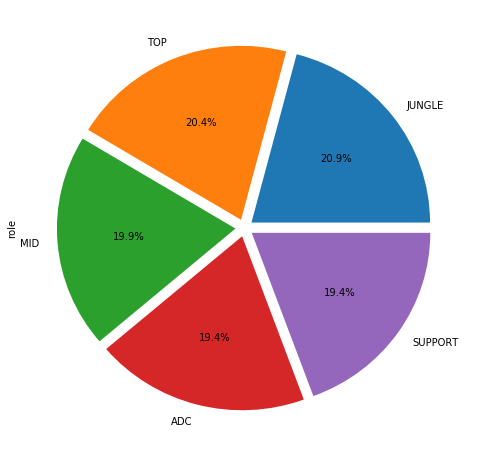

In [8]:
# Дистрибуцията на ролите е 'добра'
players.role.value_counts().plot(kind='pie', figsize=(8,8), explode=(.05, .05, .05, .05, .05), autopct='%1.1f%%')

Зареждам файла с данни от игрите, като искам да го джойнна с players по `id`. Също така трябва да си `LabelEncode`-на ролите

In [9]:
stats = pd.read_csv('data/lol-detailed/stats1.csv').head(20000)
#stats

,id,win,item1,item2,item3,item4,item5,item6,trinket,kills,...,neutralminionskilled,ownjunglekills,enemyjunglekills,totcctimedealt,champlvl,pinksbought,wardsbought,wardsplaced,wardskilled,firstblood
0,9,0,3748,2003,3111,3053,1419,1042,3340,6,...,69,42,27,610,13,0,0,10,0,0
1,10,0,2301,3111,3190,3107,0,0,3364,0,...,1,1,0,211,14,1,0,17,3,0
2,11,0,1055,3072,3006,3031,3046,1036,3340,7,...,3,1,2,182,14,1,0,13,5,0
3,12,0,1029,3078,3156,1001,3053,0,3340,5,...,6,6,0,106,15,0,0,3,0,0
4,13,0,3020,1058,3198,3102,1052,1026,3340,2,...,4,3,1,159,15,0,0,10,0,0
5,14,1,1400,3111,3078,3742,1033,3067,3340,3,...,111,81,30,808,16,0,0,8,2,0
6,15,1,3025,3193,3068,3047,1028,3082,3363,4,...,6,0,6,179,16,1,0,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19993,20002,1,3301,3504,2049,3047,3028,0,3340,2,...,0,0,0,139,12,0,1,14,0,0
19994,20003,1,1055,1055,3031,3006,2003,3086,3340,3,...,1,0,1,77,12,0,0,1,0,1


In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [79]:
data = pd.merge(players[['id', 'role']], stats, on=['id'])
data.role = LabelEncoder().fit(data.role).transform(data.role)
y = data.role
x = data.drop('role', axis=1)

In [76]:
#x

In [16]:
y.value_counts()

1    4056
4    3960
2    3851
3    3758
0    3758
Name: role, dtype: int64

In [30]:
def regression_features(X, model, start, end):
    plt.figure(figsize=(12,8))
    barplot = sns.barplot(x=X.columns[start:end], y=model.coef_[0][start:end], orient='vertical')
    plt.setp(barplot.get_xticklabels(), rotation=90)
    plt.grid(True)

In [31]:
def random_forest_features(model, X):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 10))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns, rotation='vertical')
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.preprocessing import minmax_scale

### *baseline* модел

In [63]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
model = LogisticRegression(random_state=0)
model.fit(x_train,y_train)
print('Train score: ',model.score(x_train, y_train))
print('Test score: ',model.score(x_test, y_test))

Train score:  0.84721744514
Test score:  0.84874122988


Поразгледах документацията на LogisticRegression и видях че има значение какъв ми е солвъра - понеже имам повече от два класа на данните дефоултния солвър ми върши по-лоша работа от някои от другите.
###### TODO: след като нормализирам данните да пробвам със солвър ‘sag' или ‘saga’

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
model = LogisticRegression(random_state=0, n_jobs=4, solver='newton-cg')
model.fit(x_train,y_train)
print('Train score: ', model.score(x_train, y_train))
print('Test score: ', model.score(x_test, y_test))

Train score:  0.883400976818
Test score:  0.877837391663


In [65]:
#regression_features(x, model,0, 55)
# да си подредя класовете така че total_minions_killed да няма толкова голямо значение, както и обратното за да видя какво ще стане

### Decision Trees

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
dtc = DecisionTreeClassifier(random_state=0, criterion='entropy')
tree_model = dtc.fit(x_train, y_train)
print('Train score: ', tree_model.score(x_train, y_train))
print('Test score: ', tree_model.score(x_test, y_test))

Train score:  1.0
Test score:  0.853074700784


както се очакваше, този модел overfit-ва супер много

In [66]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
dtc = DecisionTreeClassifier(random_state=0, min_samples_split=100, criterion='entropy')
tree_model = dtc.fit(x_train, y_train)
print('Train score: ', tree_model.score(x_train, y_train))
print('Test score: ', tree_model.score(x_test, y_test))

Train score:  0.903006122309
Test score:  0.871440363186


това е по-добре, но все още не е по-добро от регресията. Ще пробвам с random forest. Също така забелязах, че `entropy` критерият дава по-добър резултат. 

In [67]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
rfc = RandomForestClassifier(random_state=0, min_samples_split=150, criterion='entropy', n_jobs=4)
forest_model = rfc.fit(x_train, y_train)
print('Train score: ', forest_model.score(x_train, y_train))
print('Test score: ', forest_model.score(x_test, y_test))

Train score:  0.891449404967
Test score:  0.882789929839


In [70]:
#random_forest_features(rfc, x_train)

Лошо. Трябва да премахна тези фийчъри защото е овърфитнало мощно по Id, както и Win не ни носи никаква информация на пръв поглед.

In [26]:
#search = GridSearchCV(rfc, {'n_estimators': [10, 50, 100],
#                          'max_depth': [6, 8, 10, 12],
#                         'min_samples_split': [100,150,200]})
#search.fit(x_train, y_train)

#pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score')

След справка със search-а (която отне няколко минути и затова съм закоментирал), се оказа че различните параметри нямат кой знае какво подобрение(говоря за 0.885946 max score)

### Data Exploration
- да пробвам да разделя убитите миниони на няколко групи
- нормализация
- кда=(kills + assists)/deaths
- wardscore на базата на pinksbought, wardsbought, wardsplaced, wardskilled(отпадна, защото забелязах че има фийчър `visionscore`)
- размешване на лейбълите, така че убитите миниони да не влиаят толкова много(мързеше ме, пък и не мисля, че ще има полза)
- one hot encoding на item1... item6 ще се получат 3933 * 6 нови фййчъра, освен ако се абстрахирам от позицията на айтъма и единствено казвам дали има този айтъм(това работи дори и ако го има повече от веднъж) тогава ще се получат само 3933 нови фийчъра което е ОК.

In [147]:
#x = x.drop(['id', 'win'], axis=1)

# добавяне на 'kda' фийчър
data1 = x.copy()
data1.loc[data1.deaths == 0, 'kda'] = x.kills + x.assists
data1.loc[data1.deaths != 0, 'kda'] = (x.kills + x.assists)/x.deaths

# добавих one-hot-encoding за items
# беше много бавно и не доведе до подобрение
# тук съм го направил малко по-общо, но мисля че ако го направя за item1...item6 пак няма да има полза
#data2 = c.copy()
#data2 = data2.drop(['item1', 'item2', 'item3','item4','item5','item6'], axis=1)
#for i in range(0, x.item1.max()):
#    data2['hasitem'+str(i)] = (((x.item1 == i).astype(float) + (x.item2 == i).astype(float) + (x.item3 == i).astype(float) 
#        + (x.item4 == i).astype(float) + (x.item5==i).astype(float) + (x.item6 == i).astype(float)) > 0).astype(float)

# Тук разделям убитите миниони на 3 класа - не доведе до подобрение
data3 = data1.copy()
#data3 = data3.drop('totminionskilled', axis=1)
data3['lessThan70MinionsKilled'] = (x.totminionskilled < 70).astype(float)
data3['70To130MinionsKilled'] = (((x.totminionskilled >= 70).astype(float) + (x.totminionskilled <= 130).astype(float)) == 2).astype(float)
data3['moreThan130MinionsKilled'] = (x.totminionskilled > 130).astype(float)

# Тук си играя с minmax_scale
data4 = x.copy()
data4 = data4.drop(['pinksbought', 'wardsbought', 'wardsplaced', 'wardskilled'], axis=1)
data4[['totminionskilled', 'champlvl', 'totcctimedealt', 'item1', 
      'item2', 'item3', 'item4', 'item5', 'item6', 
       'kills', 'deaths', 'assists',
      'totunitshealed', 'largestkillingspree', 'killingsprees']] = minmax_scale(data4[['totminionskilled', 'champlvl', 'totcctimedealt', 'item1', 
      'item2', 'item3', 'item4', 'item5', 'item6', 
      'kills', 'deaths', 'assists',
      'totunitshealed', 'largestkillingspree', 'killingsprees']])

data5 = x.copy()
data5 = minmax_scale(data5)

In [152]:
data3.shape
data3[['champlvl']] = minmax_scale(data3[['champlvl']])

In [153]:
x_train, x_test, y_train, y_test = train_test_split(data3, y, random_state=0)
model = LogisticRegression(random_state=0, n_jobs=4, solver='newton-cg')
model.fit(x_train,y_train)
print('Train score: ', model.score(x_train, y_train))
print('Test score: ', model.score(x_test, y_test))
#regression_features(x_train, model,0, 50)

Train score:  0.878104148036
Test score:  0.87267849773


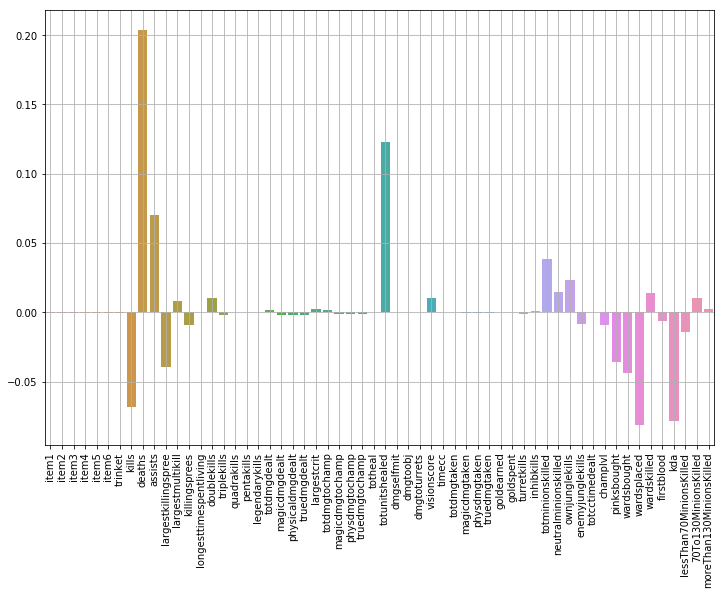

In [154]:
regression_features(x_train, model,0, 58)

Train score:  0.8982596134
Test score:  0.886710689228


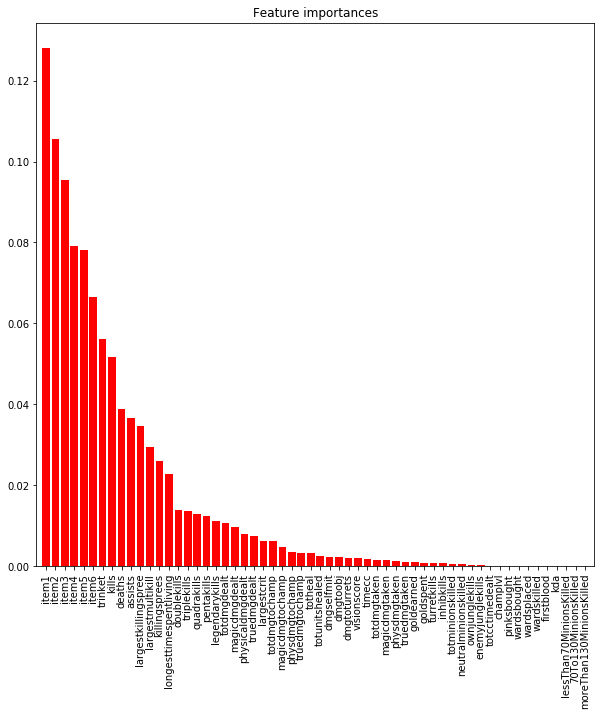

In [155]:
x_train, x_test, y_train, y_test = train_test_split(data3, y, random_state=0)
rfc = RandomForestClassifier(random_state=0, min_samples_split=120, criterion='entropy', n_jobs=4)
forest_model = rfc.fit(x_train, y_train)
print('Train score: ', forest_model.score(x_train, y_train))
print('Test score: ', forest_model.score(x_test, y_test))
random_forest_features(rfc, x_train)

## Резултати
За логистичната регресия открих че е най-добре да ползвам солвър `newton-cg` ако не съм скалирал данните, докато за скалирани данни `sag` увеличи точността с 0.03 единици.

За random forest след разцъкване на параметрите и един GridSearch който не ми даде никакви добри резултати открих че оптималните `min_samples_split` са около 100.

#### Добавяне на фийчър `kda=(kill+assists)/deaths`
Тази модификация ми донесе най-добри подобрения, като забелязах следните особености:
1. Ако използвам фийчъра, но премахна kills, assits & deaths от сета, точността пада
2. Ако използвам фийчъра заедно с другите фийчъри на които е линейна комбинация точността се вдига


- RandomForestBest:

`Train score:  0.901630322625
Test score:  0.89042509286`

- LogisticRegression

`Train score:  0.88360734677
Test score:  0.877837391663`

#### Разделяне на `totminionskilled` на 3 класа: под 70, между 70 и 130, 130+
Забелязах известно подобрения ако добавя новите класове и премахна старият фийчър. Тук също се наблюдаваше подобрение на точността ако едновременно използвам и новите фийчъри и `totminionskilled`

- RandomForestBest:

`Train score:  0.8982596134
Test score:  0.886710689228`

- LogisticRegression

`Train score:  0.880786957419
Test score:  0.874122988031`

#### `kda` + 3-те класа `totminionskilled` и скалиране на `champlvl`
- RandomForestBest:

`Train score:  0.893719474445
Test score:  0.884853487412`

- LogisticRegression

`Train score:  0.878104148036
Test score:  0.87267849773`

#### One-Hot-Encode на `items`
Избрах да не кодирам всичките 6 колони, ами вместо това направих по една колона за всеки възможен `item` и след това проверявах дали този `item` се среща някъде в колона `item1` ... `item6` и това ми беше критерият за флага дали ще е `True`. Това също не даде много добри резултати и на всичкото отгоре беше супер бавно(>1час).


Тук открих един интересен начин да се извикват векторизирано по няколко логически оператора върху един и същ сет, като проблема беше че Python не дава:

`data2['hasitem'+str(i)] = (((x.item1 == i) | (x.item2 == i) | (x.item3 == i) | (x.item4 == i) | (x.item5==i) | (x.item6 == i)) > 0).astype(float)`

Затова замених `|` с `+` и после ако сме имали `|` проверявам с `><брой_условия>`, ако съм имал `&` проверявам с `==<брой_условия>` 
        
#### Скалиране на някои features и премахване на други не толкова важни(data4) :
Тук постепенно скалирах все повече фийчъри и от графиката на важност на фийчърите забелязвах следващите които да пипна. В крайна сметка имаше по-малко фийчъри които да са с голямо тегло, но точността(за логистичната регресия) падна.
- RandomForestBest:

`Train score:  0.897227763638
Test score:  0.886504333471`

- LogisticRegression

`Train score:  0.840682396643
Test score:  0.837391663227`
- LogisticRegression със солвър 'sag' и скалирани всичките данни

`Train score:  0.871018779666
Test score:  0.864424267437`